<a href="https://colab.research.google.com/github/dolmani38/ai_corona/blob/master/analysis_corona_0507.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

로밍등록자수 정보의 Numeric timeseries data와 뉴스정보의 Unstructured text data를 혼합하여 향후 15일간의 입국자수를 예측한다.
이하 분석 방법과 알고리즘은 이번 코로나 상황에서 우리나라 입국자 수를 예측하는데 뿐만아니라 일반화 하여 뉴스 정보를 포함한 각종 시계열 정보를 예측하는데도 효과적으로 사용 될 수 있을 것으로 기대한다.


<b>1. Forecast with numeric timeseries data</b>
   <br>로밍등록자 시계열 data와 뉴스에서 BERT embedding기반 6개의 주요 feature를 추출한 시계열 data를 혼합하여 1D Convolution에 의한 regression으로 입국자를 추정한다.

<b>2. Forecast with unstructured text timeseries data (제출 내용 아님)</b>
   <br>News의 BERT embedding 전체를 1D Convolution에 의한 regression으로 입국자를 추정한다.정성적 data를 통해 정량적 data를 예측하는 것은 모순이 있으나, "3. Forecast with combined numeric timeseries and unstructured timeseries data"을 위한 예비 Test로서 시행해 본다.

<b>3. Forecast with combined numeric timeseries and unstructured timeseries data (제출 내용 아님)</b>
   <br>마지막으로 로밍등록자 시계열 data와 News의 BERT embedding 전체 시계열 data를 합친 Multi input, Mixed data 1D+2D Convolution model에 의해 입국자를 추정한다.


 1. Forecast with numeric timeseries data<br>
	1.1 Roaming Data의 전처리 및 분석
 		1.1.1 Roaming Data의 load
 		1.1.2 Roaming Data에 대한 EDA
 			1.1.2.1 도착일을 기준으로 입국자(로밍등록자)의 합산
 			1.1.2.2 입국자(로밍등록자) 추세 chart 확인
 		1.1.3 Roaming Data의 전처리
 			1.1.3.1 iso 별로 재배열
 			1.1.3.2 2주 (14일) 평균 추세 추가.
 			1.1.3.3 Trainingset의 구성
 		1.1.4 CNN model 구성 
 		1.1.5 model training
 			1.1.5.1 model training
 			1.1.5.2 trainset에 의한 입국자(로밍등록자) 예측 역산 
 			1.1.5.3 과거 Data에서 실등록자 count와 예측 count의 비교 
 		1.1.6  향후 15일 예측
 			1.1.6.1 testset (마지막 30일)의 inference
 			1.1.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출
 	1.2 News Data의 전처리
		1.2.1 News Data load
 		1.2.2 News Data에 대한 EDA
 			1.2.2.1 게시일을 기준으로 News buzz의 합산
 			1.2.2.2 하루 최대 buzz count 추출
 			1.2.2.3 News buzz 추세 Chart
 		1.2.3 News Data의 전처리
 			1.2.3.1 BERT embedding 준비
 			1.2.3.2 News의 BERT embedding
 			1.2.3.3 News data의 feature 추출 (차원 축소)
			1.2.3.4 News feature의 Normalization
			1.2.3.5 Outlier 제거
			1.2.3.6 Scale 보정
	1.3 Roaming Data와 News Data의 통합 Dataset 구성
	1.4 통합 Dataset 의 전처리
		1.4.1 시계열 분석을 위한 slidng window적용 Trainset의 구성
	1.5 통합 CNN Model 구성
	1.6 통합 CNN 학습
		1.6.1 model training
 		1.6.2 trainset에 의한 입국자(로밍등록자) 예측 역산 
 	1.7 통합 향후 15일 예측
 		1.7.1 testset (마지막 30일)의 inference
 		1.7.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출
	1.8 ensemble에 의한 15일 예측
		1.8.1 train 100회 시행
		1.8.2 trainset에 의한 입국자(로밍등록자) 예측 역산 
		1.8.3 testset (마지막 30일)의 inference
		1.8.3 신뢰수준 95%에서 입국자 예측 결과  

In [1]:
# 분석에 필요한 많이 쓰는 함수 미리 정의

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
# custom R2-score metrics for keras backend
from keras import backend as K

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def plot_mae(hist):
    plt.plot(hist.history['mae'])
    plt.title('mean_absolute_error')
    plt.ylabel('mae')
    plt.xlabel('Epoch')
    plt.legend(['mae'], loc='upper right')
    plt.show()

def plot_r2(hist):
    plt.plot(hist.history['r2'])
    plt.title('R square')
    plt.ylabel('R^2')
    plt.xlabel('Epoch')
    #plt.legend(['mae'], loc='upper right')
    plt.show()

def compare_backdata(predit_y):
    predit = []
    for forecast in range(forecast_days):
        predit.append(list(np.concatenate((np.zeros(window+ forecast), predit_y[:,forecast],np.zeros(forecast_days-forecast-1)), axis=0)))
    # 예측치를 chart에 같이 그려서 확인
    comp_ds = raw_ds.copy()
    comp_ds['predict_arrival_1'] = predit[0]
    comp_ds['predict_arrival_15'] = predit[14]
    comp_ds.plot(y=['total','predict_arrival_1','predict_arrival_15'],figsize=(16,8))

def display_result(predit_y,title=None):
  predic_ds = []
  # 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
  #predit_y1 = predit_y * 100/24
  from datetime import datetime, timedelta
  last_date = raw_ds.index[-1]
  for predict_count in predit_y[0]:
    last_date += timedelta(days=1)
    predic_ds.append({'date':last_date,'roaming register forecate':predict_count, 'immigrantion forecast':int(predict_count * 100/24)})
  predic_ds = pd.DataFrame(predic_ds)
  predic_ds.plot(x='date',y='immigrantion forecast',kind='bar',title=('immigrantion forecast' if title is None else title))
  return predic_ds

class VerboseCallback(keras.callbacks.Callback):
    def __init__(self,epoch):
        self.epoch = epoch
        self.progress("learning:",0,[])
        
    def progress(self,text,current=0,log=None):
        g = self.epoch-current
        f = 50 / self.epoch 
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50-c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current,self.epoch,''.join(pg), ('' if log is None else log)), end="", flush=True)
        if self.epoch-current == 0:
            print("")        
            
    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:",epoch+1,logs)



Using TensorFlow backend.


In [2]:
# 1. Forecast with numeric timeseries data
#	1.1 Roaming Data의 전처리 및 분석
# 		1.1.1 Roaming Data의 load

#공개된 3개의 Roaming Dataset을 load하여 합친다.
rm1 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/Roaming_data.csv",encoding="utf-8")
rm2 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/Roaming_data.csv",encoding="utf-8")
rm = pd.concat([rm1, rm2], ignore_index=True, sort=False)

# 합친 Dataset의 내용 확인
rm

,return,iso,arrival,departure,count
0,20200131,ad,20200130,20200130,3
1,20200131,ae,20191231,20200125,3
2,20200131,ae,20191231,20200131,3
3,20200131,ae,20200102,20200102,3
4,20200131,ae,20200104,20200131,3
...,...,...,...,...,...
217800,20200401,vn,20200330,20200401,3
217801,20200401,vn,20200331,20200331,20
217802,20200401,vn,20200331,20200401,6
217803,20200401,vn,20200401,20200401,45


In [3]:
# 		1.1.2 Roaming Data에 대한 EDA
# 			1.1.2.1 도착일을 기준으로 입국자(로밍등록자)의 합산

ar = pd.DataFrame(rm.groupby('arrival')['count'].sum())
ar['date'] =  ar.index.astype('object')
#date column을 datetime 으로 casting 한다.
ar['date'] =  pd.to_datetime(ar['date'], format='%Y%m%d')

# 날자별 입국자(로밍등록자) 정리 dataset 확인
ar

,count,date
arrival,,
20191031,91,2019-10-31
20191101,36,2019-11-01
20191102,120,2019-11-02
20191103,159,2019-11-03
20191104,179,2019-11-04
...,...,...
20200424,711,2020-04-24
20200425,463,2020-04-25
20200426,447,2020-04-26


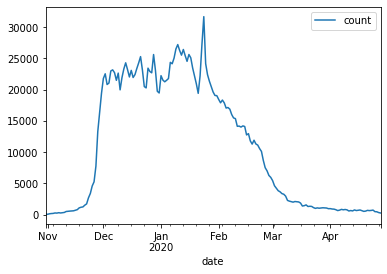

In [4]:
# 			1.1.2.2 입국자(로밍등록자) 추세 chart 확인
ar.plot(x='date',y='count')

In [5]:
# 		1.1.3 Roaming Data의 전처리
# 			1.1.3.1 iso 별로 재배열

ar_iso = pd.DataFrame(rm.groupby(['arrival','iso'])['count'].sum())
rows = []
date = None
r = None
for row in ar_iso.iterrows():
    if date == row[0][0]:
        pass
    else:
        if not r is None:
            rows.append(r)
        r = {}
    r['arrival'] = row[0][0]
    r[row[0][1]] = row[1][0]
    date = row[0][0]
rows.append(r)
ds_iso = pd.DataFrame(rows)
ds_iso.fillna(0, inplace=True)
ds_iso = ds_iso.set_index('arrival')
ds_iso['total'] = ar['count']
ds_iso.index =  ds_iso.index.astype('object')
#index을 datetime 으로 casting 한다.
ds_iso.index =  pd.to_datetime(ds_iso.index, format='%Y%m%d')
ds_iso

,ae,at,cn,de,hk,jp,kh,kw,la,mm,my,no,pe,ph,pl,th,us,vn,hu,ma,mn,au,ch,fr,gb,in,iq,lk,qa,sg,uz,cz,dk,es,fi,id,nz,ru,sa,sk,...,tp,vu,zw,rs,tk,ug,bz,bo,cy,na,pg,rw,bt,lr,mz,pr,tg,mk,an,cv,tt,md,ad,ga,gn,re,ky,bf,bj,cf,tc,ls,td,mr,to,ws,gm,ye,ml,total
arrival,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,8,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91
2019-11-01,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36
2019-11-02,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6,19.0,3.0,0.0,0.0,0.0,6.0,3.0,6.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120
2019-11-03,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,13,21.0,6.0,3.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159
2019-11-04,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,6,24.0,9.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,6.0,6.0,3.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,0.0,12.0,84,34.0,19.0,157,0.0,0.0,0.0,3.0,3.0,0.0,0.0,30.0,0.0,18,62.0,44.0,6.0,0.0,3.0,3.0,0.0,9.0,12.0,6.0,0.0,0.0,0.0,6.0,6.0,0.0,6.0,3.0,0.0,28.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,711
2020-04-25,0.0,9.0,39,15.0,4.0,111,21.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,0.0,6,73.0,27.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463
2020-04-26,0.0,0.0,42,14.0,10.0,98,6.0,0.0,0.0,0.0,3.0,0.0,0.0,12.0,0.0,3,50.0,40.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,27.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447


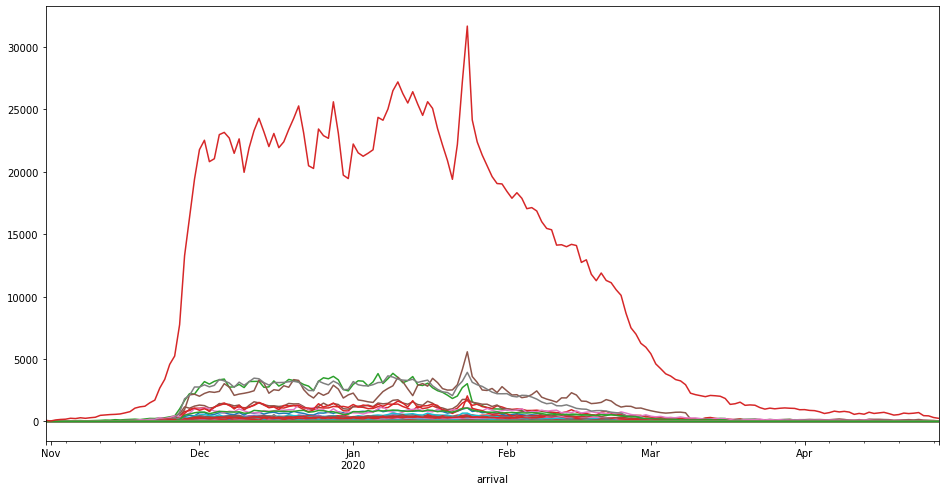

In [6]:
ds_iso.plot(legend=False,figsize=(16,8))

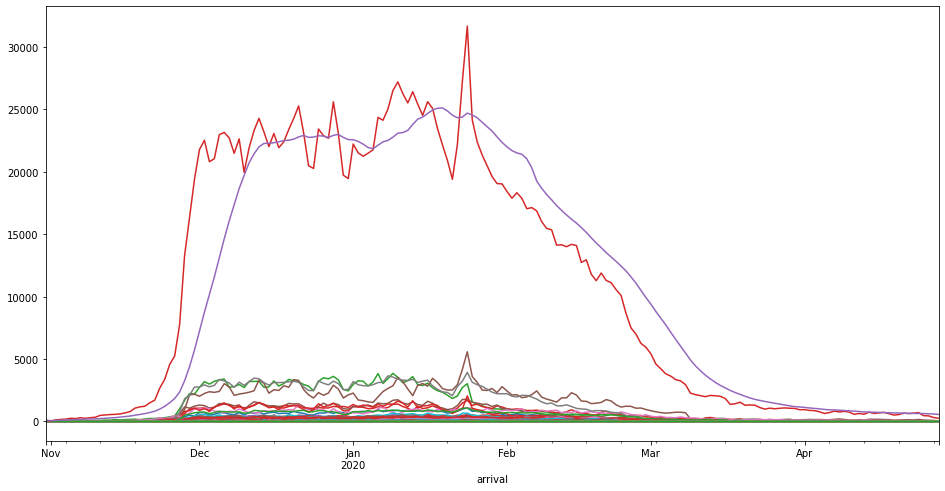

In [7]:
# 			1.1.3.2 2주 (14일) 평균 추세 추가.
raw_ds = ds_iso.copy()
# scale을 조정하기 위해 /5 처리 
raw_ds['arrival_14ma'] = raw_ds['total'].rolling(window=14, min_periods=0).mean()
raw_ds.plot(legend=False,figsize=(16,8))

In [8]:
# 추가 데이터
# COVID-19 word wide dataset
# https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data

cov_ww = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/data/covid19_ww.csv",encoding="utf-8")
cov_ww

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,07/05/2020,7,5,2020,168,9,Afghanistan,AF,AFG,37172386.0,Asia
1,06/05/2020,6,5,2020,330,5,Afghanistan,AF,AFG,37172386.0,Asia
2,05/05/2020,5,5,2020,190,5,Afghanistan,AF,AFG,37172386.0,Asia
3,04/05/2020,4,5,2020,235,13,Afghanistan,AF,AFG,37172386.0,Asia
4,03/05/2020,3,5,2020,134,4,Afghanistan,AF,AFG,37172386.0,Asia
...,...,...,...,...,...,...,...,...,...,...,...
15485,25/03/2020,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
15486,24/03/2020,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0,Africa
15487,23/03/2020,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
15488,22/03/2020,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0,Africa


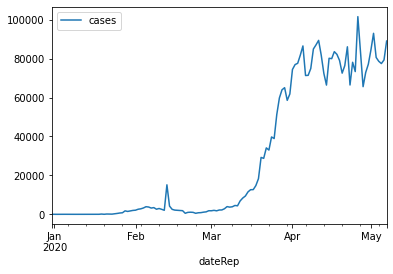

In [9]:
cov_ww_ds = pd.DataFrame(cov_ww.groupby('dateRep')['cases'].sum())
#date column을 datetime 으로 casting 한다.
cov_ww_ds.index =  pd.to_datetime(cov_ww_ds.index, format='%d/%m/%Y')
cov_ww_ds = cov_ww_ds.sort_index()

cov_ww_ds.plot()

In [10]:
raw_ds = raw_ds.join(cov_ww_ds)
raw_ds.fillna(0)
raw_ds

,ae,at,cn,de,hk,jp,kh,kw,la,mm,my,no,pe,ph,pl,th,us,vn,hu,ma,mn,au,ch,fr,gb,in,iq,lk,qa,sg,uz,cz,dk,es,fi,id,nz,ru,sa,sk,...,zw,rs,tk,ug,bz,bo,cy,na,pg,rw,bt,lr,mz,pr,tg,mk,an,cv,tt,md,ad,ga,gn,re,ky,bf,bj,cf,tc,ls,td,mr,to,ws,gm,ye,ml,total,arrival_14ma,cases
arrival,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,8,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91,91.000000,NaN
2019-11-01,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,63.500000,NaN
2019-11-02,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6,19.0,3.0,0.0,0.0,0.0,6.0,3.0,6.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120,82.333333,NaN
2019-11-03,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,13,21.0,6.0,3.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159,101.500000,NaN
2019-11-04,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,6,24.0,9.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,6.0,6.0,3.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179,117.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,0.0,12.0,84,34.0,19.0,157,0.0,0.0,0.0,3.0,3.0,0.0,0.0,30.0,0.0,18,62.0,44.0,6.0,0.0,3.0,3.0,0.0,9.0,12.0,6.0,0.0,0.0,0.0,6.0,6.0,0.0,6.0,3.0,0.0,28.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,711,638.071429,78087.0
2020-04-25,0.0,9.0,39,15.0,4.0,111,21.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,0.0,6,73.0,27.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463,630.642857,73307.0
2020-04-26,0.0,0.0,42,14.0,10.0,98,6.0,0.0,0.0,0.0,3.0,0.0,0.0,12.0,0.0,3,50.0,40.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,27.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447,616.785714,101533.0


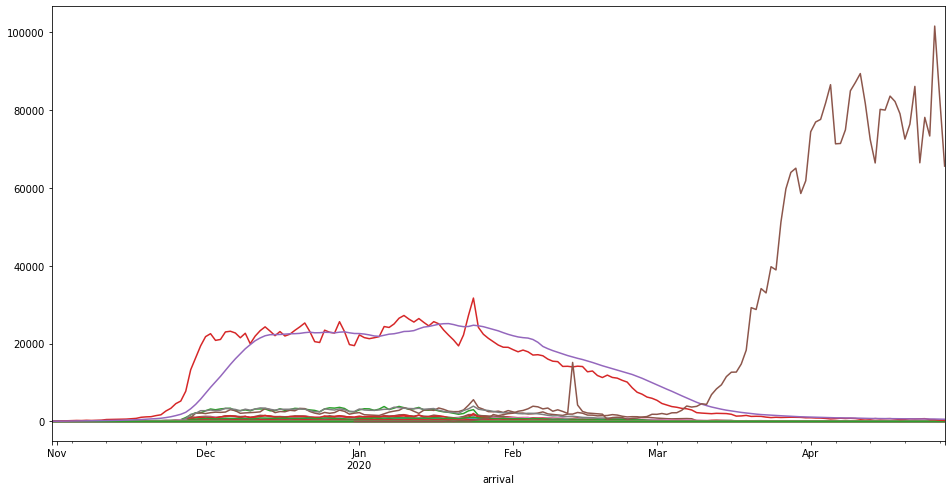

In [11]:
raw_ds.plot(legend=False,figsize=(16,8))

In [12]:
# 	1.2 News Data의 전처리
#		1.2.1 News Data load

# 뉴스 기사 정보를 읽어서... 나뉘어 있는 Dataset을 합친다.
ns1 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/NewsList.xls")
ns2 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/NewsList.xls")
ns =pd.concat([ns1, ns2], ignore_index=True, sort=False)
ns

,파일명,제목,URL,수집일자,게시일자,채널명,감염병명,분류명
0,AFRO2019120200003,WHO supports Angola’s Government efforts to en...,https://www.afro.who.int/news/who-supports-ang...,2019-12-02 21:00:16.0,2019-12-02 00:00:00,AFRO,Poliomyelitis,Viral
1,AFRO2019120300001,African First Ladies laud progress against HIV...,https://www.afro.who.int/news/african-first-la...,2019-12-03 00:00:17.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
2,AFRO2019120300002,Eritrea Observed World AIDS Day 2019,https://www.afro.who.int/news/eritrea-observed...,2019-12-03 00:00:18.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
3,AFRO2019120400003,West and Central Africa Expands Access to HIV ...,https://www.afro.who.int/news/west-and-central...,2019-12-04 03:00:14.0,2019-12-03 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
4,AFRO2019120400004,Nearly 23 million voluntary male medical circu...,https://www.afro.who.int/news/nearly-23-millio...,2019-12-04 22:00:14.0,2019-12-04 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
...,...,...,...,...,...,...,...,...
103822,XWFB2020040900020,"Ching Ming remembrance, home country forever! ...",http://wsjkw.sh.gov.cn/xwfb/20200404/2f54e0e14...,2020-04-09 16:05:21.0,2020-04-04 00:00:00,Shanghai Municioal Health Commission,COVID-19,Viral
103823,ZWYW2020041000002,Guangdong Provincial Health Commission notifie...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-10 18:00:45.0,2020-04-10 00:00:00,Health Commission of Guangdong Province,Dengue fever,Viral
103824,ZWYW2020041500002,Guangdong Provincial Health Commission announc...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:04.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral
103825,ZWYW2020041500003,Guangdong Provincial Health Commission release...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:13.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral


In [13]:
# 		1.2.2 News Data에 대한 EDA
# 			1.2.2.1 게시일을 기준으로 News buzz의 합산

cov_news = ns.loc[ns['감염병명'] == 'COVID-19']
cov_news['게시일자'] =  cov_news['게시일자'].str[:10]
cov_buz = pd.DataFrame(cov_news.groupby('게시일자')['감염병명'].count())
cov_buz = cov_buz.loc[cov_buz.index >= '2019-10-31']
cov_buz['date'] = pd.to_datetime(cov_buz.index, format='%Y-%m-%d')
cov_buz = cov_buz.rename(columns={"감염병명":"buz_count"})
cov_buz

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,buz_count,date
게시일자,,
2019-12-01,1,2019-12-01
2019-12-14,2,2019-12-14
2019-12-30,3,2019-12-30
2019-12-31,5,2019-12-31
2020-01-02,1,2020-01-02
...,...,...
2020-04-26,1176,2020-04-26
2020-04-27,1353,2020-04-27
2020-04-28,999,2020-04-28


In [14]:
# 			1.2.2.2 하루 최대 buzz count 추출

max_buz_per_day = cov_buz['buz_count'].max()
max_buz_per_day

1948

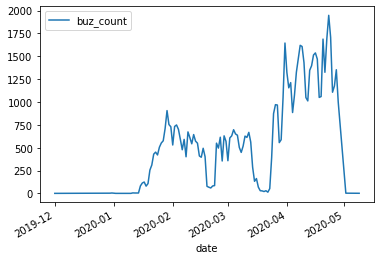

In [15]:
# 			1.2.2.3 News buzz 추세 Chart

cov_buz.plot(x='date',y='buz_count')

In [16]:
# 		1.2.3 News Data의 전처리
# 			1.2.3.1 BERT embedding 준비

# Sentence Transformers: Multilingual Sentence Embeddings using BERT / RoBERTa / XLM-RoBERTa & Co. with PyTorch
# https://github.com/UKPLab/sentence-transformers

!pip install -U sentence-transformers

# BERT Test Code...

"""
This is a simple application for sentence embeddings: semantic search
We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.

This script outputs for various queries the top 5 most similar sentences in the corpus.
"""

from sentence_transformers import SentenceTransformer
import scipy.spatial

embedder = SentenceTransformer('bert-base-nli-mean-tokens')

# Corpus with example sentences
corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'A cheetah is running behind its prey.'
          ]

corpus_embeddings = embedder.encode(corpus)

# Query sentences:
queries = ['A man is eating pasta.', 'Someone in a gorilla costume is playing a set of drums.', 'A cheetah chases prey on across a field.']
query_embeddings = embedder.encode(queries)

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
closest_n = 5

for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])
    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")
    for idx, distance in results[0:closest_n]:
        print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 573kB 13.6MB/s 
     |████████████████████████████████| 890kB 51.5MB/s 
     |████████████████████████████████| 3.7MB 41.2MB/s 
     |████████████████████████████████| 1.0MB 43.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=7c4d5bdca9d08fac6ef3ab92bdb670935374e31b487f3c12b480e4df876968a4
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=24bc5932213d4ee667f5760705b907c19d3e8ed52c06b759b2cb6e689a597bd5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


100%|██████████| 405M/405M [00:24<00:00, 16.6MB/s]






Query: A man is eating pasta.

Top 5 most similar sentences in corpus:
A man is eating a piece of bread. (Score: 0.8480)
A man is eating food. (Score: 0.7759)
Two men pushed carts through the woods. (Score: 0.2095)
A monkey is playing drums. (Score: 0.1945)
A man is riding a white horse on an enclosed ground. (Score: 0.1586)




Query: Someone in a gorilla costume is playing a set of drums.

Top 5 most similar sentences in corpus:
A monkey is playing drums. (Score: 0.7985)
A cheetah is running behind its prey. (Score: 0.2860)
The girl is carrying a baby. (Score: 0.2351)
A man is riding a horse. (Score: 0.2023)
A man is riding a white horse on an enclosed ground. (Score: 0.1963)




Query: A cheetah chases prey on across a field.

Top 5 most similar sentences in corpus:
A cheetah is running behind its prey. (Score: 0.9007)
Two men pushed carts through the woods. (Score: 0.3662)
A monkey is playing drums. (Score: 0.3061)
A man is riding a horse. (Score: 0.2930)
A man is riding a whit

In [17]:
###########################################################################################################
# dolmani38의 google drive에서 corpus_embeddings.emb 의 다운로드                                          #
# dolmani38이외 Test 사용자는 이번 Cell은 실행하지 말고 다음 Cell에서 corpus_embeddings.emb를 만드세요.   #
###########################################################################################################
!pip install PyDrive
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user(clear_output=False)
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({"id":"1FN7V0RxGACTNkusH9iQgFjXhicv1Lzei"})   # replace the id with id of file you want to access
downloaded.GetContentFile("corpus_embeddings.emb")        # replace the file name with your file

import os.path
from os import path

if path.exists("corpus_embeddings.emb"):
    print("Download complete!!")

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=n7id0blFj5oT1bC9miB15mzxly7Las&code_challenge=4RAvMG12giPpztV5KR-fz0oAuF0exp_uabg8z5mrVyU&prompt=consent&code_challenge_method=S256&access_type=offline

Enter verification code: ··········
Download complete!!


In [18]:
# 			1.2.3.2 News의 BERT embedding

# 실 Contents는 사용하지 않고 title만 BERT embedding 처리...

import os.path
from os import path
import dill

temp_ds = cov_news #.head(10)
corpus = []
for row in temp_ds.iterrows():
    file_name = row[1][0]
    title = str(row[1][1])
    pub_datetime = row[1][4]
    corpus.append(title.lower())

if path.exists("corpus_embeddings.emb"):
    print("load from corpus_embeddings file...")
    file = open("corpus_embeddings.emb", 'rb')
    corpus_embeddings = dill.load(file)
    file.close()
    print("Complete!!")
else:
    corpus_embeddings = embedder.encode(corpus,show_progress_bar=True)   

    print("Wait! saving corpus_embeddings...")    
    file = open("corpus_embeddings.emb", 'wb')
    dill.dump(corpus_embeddings, file)
    file.close()
    print("Complete!!")

corpus_embeddings = np.asarray(corpus_embeddings)        
print("shape of corpus_embeddings : ",corpus_embeddings.shape)
print("length of corpus : ",len(corpus))

temp_ds = cov_news #.head(10)
docv_model = {}
for i, row in enumerate(temp_ds.iterrows()):
    docv_model[row[1][0]] = corpus_embeddings[i]

len(docv_model)

load from corpus_embeddings file...
Complete!!
shape of corpus_embeddings :  (73752, 768)
length of corpus :  73752


73306

In [19]:
# 			1.2.3.3 News data의 feature 추출 (일종의 차원 축소)

# News에서 6개 feature 추출
# worse feature : 코로나 상황이 더 나빠지고 있다는 뉴스
# better feature : 상황이 좋아 지고 있나는 뉴스
# block feature : 격리, 입출입 차단 강화 관련 뉴스
# premit feature : 격리 해제, 입출입 완화 관련 뉴스
# yes_korea feature : 한국에 긍정적 내용 뉴스
# no_korea feature : 한국에 부정적 내용 뉴스

# 6개 feature를 추출하기 위해, 각 특성을 나타내는 간략한 sentence를 수동으로 만들고, 이를 전체 corpus_embeddings 에서 유사한 내용의 뉴스를 추출하여
# 해당 뉴스를 유사 내용으로 간주하고 labeling 한다.

def searchSentence(queries,Threshold_score=0.60, Topn=0,must_has_word=[]):
    index = {}
    n = len(queries)
    query_embeddings = embedder.encode(queries)
    for query, query_embedding in zip(queries, query_embeddings):
        distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

        results = zip(range(len(distances)), distances)
        results = sorted(results, key=lambda x: x[1])
        
        for idx, distance in results[0:len(results) if Topn==0 else Topn]:
          score = 1-distance
          if not idx in index:
            index[idx] = 0.0
          if score > Threshold_score:
              if len(must_has_word) > 0:
                  if corpus[idx].strip().find(must_has_word[0]) >= 0:
                      index[idx] += float(score/n)
              else:
                  index[idx] += float(score/n)
              #print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))
    return index

cov_news.reset_index(inplace = True, drop = True) 

queries_dict = {
    'worse':([],['infected corona','infected coronavirus ','increase confirmed','increase Infections','infectious increase','confirmed case incease','deaths incease','patients incease','lack prepare','not prepared','lack medical','lack preparedness']),
    'better':([],['decrease confirmed','decrease Infections','infectious decrease','confirmed case decrease','No confirmed','No case','deaths decrease','patients decrease','send supplies','order supplies','donates supplies','gives supplies','situation stability','situation stable','remains stable']),
    'block':([],['immigrants block','immigrants restrict','immigration block','immigration restrict','entrants block','entrants restrict','entry block','entry restrict','tourist block','tourist restrict','tourist Isolation','traveler block','traveler restrict','traveler Isolation','immigrants quarantine','entrants quarantine','entry quarantine','tourist quarantine','reinforce quarantine','reinforce diagnosis']),
    'permit':([],['immigrants permit','immigrants ease','immigration permit','immigration ease','entrants permit','entrants ease','entry permit','entry ease','tourist permit','tourist ease','release tourist ','traveler permit','release quarantine','release quarantine']),
    'yes_korea':(['korea'],['korea decrease confirmed','korea decrease Infections','korea infectious decrease','korea confirmed case decrease','korea No confirmed','korea No case','korea deaths decrease','korea patients decrease','korea send supplies','korea order supplies','korea donates supplies','korea gives supplies','korea situation stability','korea situation stable','korea remains stable','korea immigrants permit','korea immigrants ease','korea immigration permit','korea immigration ease','korea entrants permit','korea entrants ease','korea entry permit','korea entry ease','korea tourist permit','korea tourist ease','korea release tourist ','korea traveler permit','korea release quarantine','korea release quarantine']),
    'no_korea':(['korea'],['korea infected corona','korea infected coronavirus ','korea increase confirmed','korea increase Infections','korea infectious increase','korea confirmed case incease','korea deaths incease','korea patients incease','korea lack prepare','korea not prepared','korea lack medical','korea lack preparedness','korea immigrants block','korea immigrants restrict','korea immigration block','korea immigration restrict','korea entrants block','korea entrants restrict','korea entry block','korea entry restrict','korea tourist block','korea tourist restrict','korea tourist Isolation','korea traveler block','korea traveler restrict','korea traveler Isolation','korea immigrants quarantine','korea entrants quarantine','korea entry quarantine','korea tourist quarantine','korea reinforce quarantine','korea reinforce diagnosis'])
}
# Query sentences:

for query_key in queries_dict.keys():
  cov_news[query_key] = 0
  idxs = searchSentence(queries_dict[query_key][1],Threshold_score = 0.6,must_has_word=queries_dict[query_key][0])
  print('{} result rows:{} query count:{}'.format(query_key,len(idxs),len(queries_dict[query_key][1])))
  cov_news.loc[list(idxs.keys()),query_key] = list(idxs.values())

cov_news[['게시일자','worse','better','block','permit','yes_korea','no_korea','제목']]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


worse result rows:73752 query count:12


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


better result rows:73752 query count:15
block result rows:73752 query count:20
permit result rows:73752 query count:14
yes_korea result rows:73752 query count:29
no_korea result rows:73752 query count:32


,게시일자,worse,better,block,permit,yes_korea,no_korea,제목
0,2020-01-25,0.054946,0.0,0.0,0.0,0.0,0.0,Rwanda Public Notice on Novel Coronavirus
1,2020-01-31,0.000000,0.0,0.0,0.0,0.0,0.0,WHO ramps up preparedness for novel coronaviru...
2,2020-02-01,0.051934,0.0,0.0,0.0,0.0,0.0,Rwanda hastens safety measures against novel c...
3,2020-02-02,0.000000,0.0,0.0,0.0,0.0,0.0,Eritrea Strengthening Preparedness to 2019 nov...
4,2020-02-04,0.000000,0.0,0.0,0.0,0.0,0.0,WHO supports Botswana’s preparedness and respo...
...,...,...,...,...,...,...,...,...
73747,2020-04-06,0.000000,0.0,0.0,0.0,0.0,0.0,This city conducts new coronavirus testing for...
73748,2020-04-06,0.000000,0.0,0.0,0.0,0.0,0.0,"Yesterday, there were no new confirmed cases o..."
73749,2020-04-05,0.000000,0.0,0.0,0.0,0.0,0.0,27 confirmed cases discharged in Shanghai toda...
73750,2020-04-05,0.000000,0.0,0.0,0.0,0.0,0.0,No new confirmed cases of local new coronary p...


In [20]:
# 6개 feature를 하나의 dataframe으로 join

cov_1 = pd.DataFrame(cov_news.groupby('게시일자')['worse'].sum())
cov_2 = pd.DataFrame(cov_news.groupby('게시일자')['better'].sum())
cov_3 = pd.DataFrame(cov_news.groupby('게시일자')['block'].sum())
cov_4 = pd.DataFrame(cov_news.groupby('게시일자')['permit'].sum())
cov_5 = pd.DataFrame(cov_news.groupby('게시일자')['yes_korea'].sum())
cov_6 = pd.DataFrame(cov_news.groupby('게시일자')['no_korea'].sum())

cov_buz = cov_buz.join(cov_1).join(cov_2).join(cov_3).join(cov_4).join(cov_5).join(cov_6)
cov_buz

,buz_count,date,worse,better,block,permit,yes_korea,no_korea
게시일자,,,,,,,,
2019-12-01,1,2019-12-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-14,2,2019-12-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-30,3,2019-12-30,0.058952,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-31,5,2019-12-31,0.170601,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,1,2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2020-04-26,1176,2020-04-26,4.730061,0.547551,0.398905,0.631497,0.000000,0.178513
2020-04-27,1353,2020-04-27,5.720956,0.697484,0.612615,1.125912,0.294945,1.551954
2020-04-28,999,2020-04-28,4.742880,0.724775,0.846569,0.726003,0.021297,1.330853


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

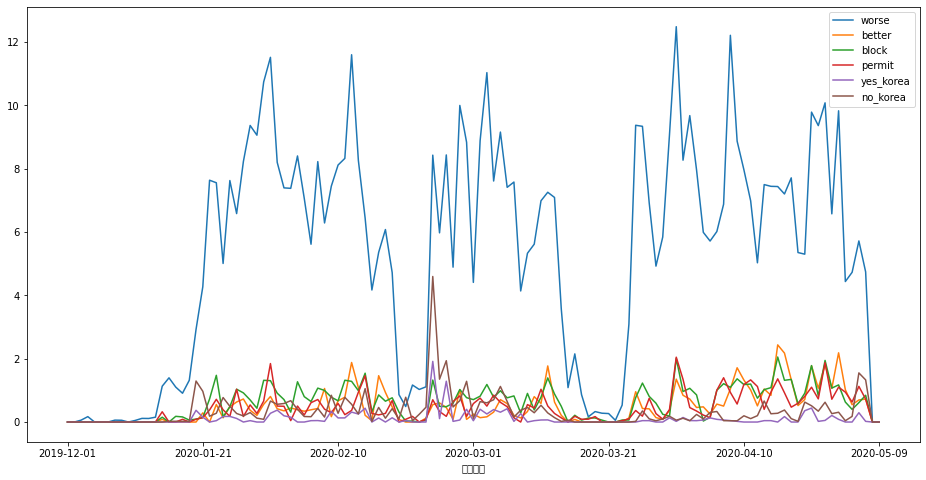

In [21]:
# 추출된 feature의 추세 확인
cov_buz.plot(y=['worse','better','block','permit','yes_korea','no_korea'],figsize=(16,8))

In [22]:
#			1.2.3.4 News feature의 Normalization

norm_cov_buz = pd.DataFrame({'worse':cov_buz['worse']/cov_buz['buz_count']})
norm_cov_buz["better"] = cov_buz['better']/cov_buz['buz_count']
norm_cov_buz["block"] = cov_buz['block']/cov_buz['buz_count']
norm_cov_buz["permit"] = cov_buz['permit']/cov_buz['buz_count']
norm_cov_buz["yes_korea"] = cov_buz['yes_korea']/cov_buz['buz_count']
norm_cov_buz["no_korea"] = cov_buz['no_korea']/cov_buz['buz_count']
norm_cov_buz

,worse,better,block,permit,yes_korea,no_korea
게시일자,,,,,,
2019-12-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-30,0.019651,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-31,0.034120,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2020-04-26,0.004022,0.000466,0.000339,0.000537,0.000000,0.000152
2020-04-27,0.004228,0.000516,0.000453,0.000832,0.000218,0.001147
2020-04-28,0.004748,0.000726,0.000847,0.000727,0.000021,0.001332


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

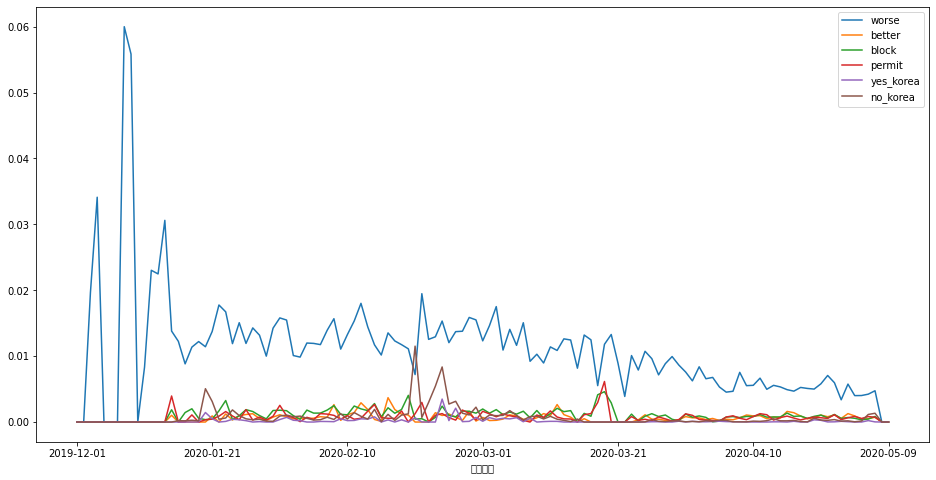

In [23]:
# Normalization 한 feature의 추세 확인

norm_cov_buz.plot(figsize=(16,8))

In [0]:
#			1.2.3.5 Outlier 제거

# worse 성분의 outlier filtering
norm_cov_buz = norm_cov_buz[norm_cov_buz["worse"] < 0.02]

In [0]:
#			1.2.3.6 Scale 보정

# raw_ds에서  columns=['total','arrival_14ma'] 를 제외 한 max값을 기준으로 norm_cov_buz 의 scale 보정 처리
#max_norm_cov_buz = np.max(norm_cov_buz.max())
#print("max in norm_cov_buz : ", max_norm_cov_buz)

#raw_ds_d = raw_ds.drop(columns=['total','arrival_14ma'])
#max_raw_ds_d = np.max(raw_ds_d.max())
#print("max in raw_ds_d : ", max_raw_ds_d)
#adj_coef = max_raw_ds_d / max_norm_cov_buz
#print("Adjustment coefficient:",adj_coef)

#norm_cov_buz = norm_cov_buz * adj_coef

#norm_cov_buz.plot(figsize=(16,8))
#raw_ds_d.plot(legend=False,figsize=(16,8))

,ae,at,cn,de,hk,jp,kh,kw,la,mm,my,no,pe,ph,pl,th,us,vn,hu,ma,mn,au,ch,fr,gb,in,iq,lk,qa,sg,uz,cz,dk,es,fi,id,nz,ru,sa,sk,...,cy,na,pg,rw,bt,lr,mz,pr,tg,mk,an,cv,tt,md,ad,ga,gn,re,ky,bf,bj,cf,tc,ls,td,mr,to,ws,gm,ye,ml,total,arrival_14ma,cases,worse,better,block,permit,yes_korea,no_korea
arrival,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,8,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91,91.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-01,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,63.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-02,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6,19.0,3.0,0.0,0.0,0.0,6.0,3.0,6.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120,82.333333,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-03,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,13,21.0,6.0,3.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159,101.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-04,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,6,24.0,9.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,6.0,6.0,3.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179,117.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,0.0,12.0,84,34.0,19.0,157,0.0,0.0,0.0,3.0,3.0,0.0,0.0,30.0,0.0,18,62.0,44.0,6.0,0.0,3.0,3.0,0.0,9.0,12.0,6.0,0.0,0.0,0.0,6.0,6.0,0.0,6.0,3.0,0.0,28.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,711,638.071429,78087.0,0.005756,0.001280,0.000687,0.000645,0.000049,0.000181
2020-04-25,0.0,9.0,39,15.0,4.0,111,21.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,0.0,6,73.0,27.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463,630.642857,73307.0,0.004009,0.000922,0.000569,0.000853,0.000000,0.000037
2020-04-26,0.0,0.0,42,14.0,10.0,98,6.0,0.0,0.0,0.0,3.0,0.0,0.0,12.0,0.0,3,50.0,40.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,27.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447,616.785714,101533.0,0.004022,0.000466,0.000339,0.000537,0.000000,0.000152


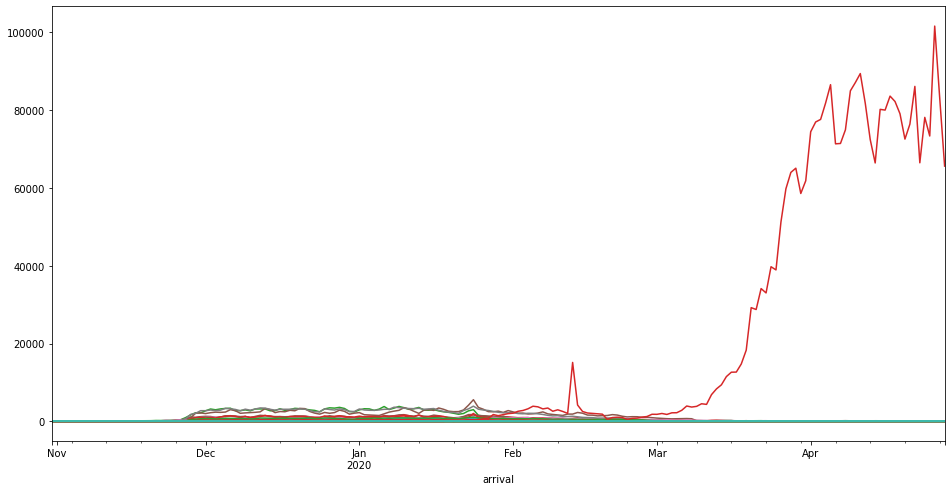

In [26]:
#	1.3 Roaming Data와 News Data의 통합 Dataset 구성

raw_ds_ns = raw_ds.join(norm_cov_buz)
raw_ds_ns = raw_ds_ns.fillna(0)

raw_ds_ns.drop(columns=['total','arrival_14ma']).plot(legend=False,figsize=(16,8))
raw_ds_ns


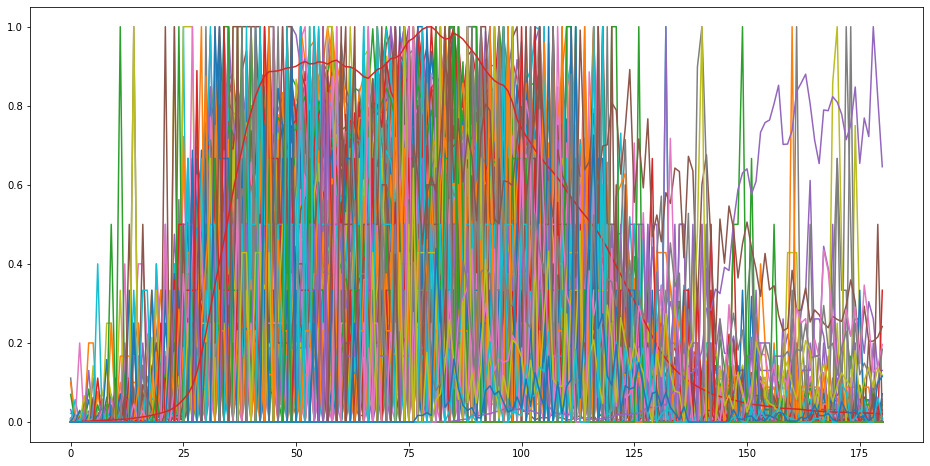

In [28]:
#	1.4 통합 Dataset 의 전처리
#		1.4.1 시계열 분석을 위한 slidng window적용 Trainset의 구성

# Time-series CNN을 적용하기 위한 전처리
# 1D Convolution을 적용하기 위해.

import numpy as np
from sklearn import preprocessing

train_org_y = raw_ds_ns['total'].to_numpy()
data = (raw_ds_ns.drop(columns=['total'])).to_numpy()

#normalization
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)
df = pd.DataFrame(data)
df.plot(legend=False,figsize=(16,8))

In [29]:

# window를 30일로 설정 -> 그냥 잡은 수치
window = 30
#입력 feature 개수.
size = len(raw_ds_ns.columns) - 1 # totoal column 제외
#향후 15일 예측
forecast_days = 15



train_x = []
train_y = []

for i in range(data.shape[0]-window-forecast_days + 1):
    sub_x = []
    for j in range(window):
        sub_x.append(data[i+j,:])
    train_x.append(sub_x)

    sub_y = []
    for z in range(forecast_days):
        sub_y.append(train_org_y[i + window + z])
    train_y.append(sub_y)

#train_x ,train_y의 준비
train_x = np.asarray(train_x)
train_x = train_x.reshape(-1,window,size)
train_y = np.asarray(train_y)

test_x = data[data.shape[0]-window:data.shape[0],:]
#train_x ,train_y의 내용 확인.
train_x.shape, train_y.shape, test_x.shape

((137, 30, 181), (137, 15), (30, 181))

In [30]:
#	1.5 통합 CNN Model 구성

# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,4, input_shape=(window, size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(32))
model.add(Dense(forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

print(model.summary())

model_json = model.to_json()
with open("combined_model.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()

print("save to combined_model.json")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 128)           92800     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 64)            32832     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 32)            

In [37]:
#	1.6 통합 CNN 학습
#		1.6.1 model training

def train_combined_model(trial,epochs=30,verbose=0,metrics=['mae',r2]):
    from keras.models import model_from_json
    json_file = open("combined_model.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=metrics)
    #print(model.summary())
    print(str(trial),"th Trial")
    if verbose == 0:
        hist = model.fit(train_x, train_y, epochs=epochs,verbose=0,callbacks=[VerboseCallback(epochs)])
    else:
        hist = model.fit(train_x, train_y, epochs=epochs,verbose=1)
    return model,hist

model,hist = train_combined_model(1,epochs=200)


1 th Trial
learning:200/200[==================================================]{'loss': 2143088.638686131, 'mae': 854.18054, 'r2': 0.9781705}


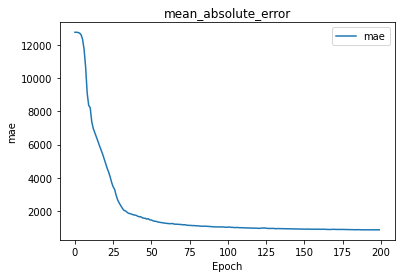

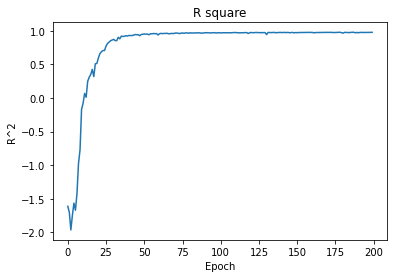

In [38]:
# train measure 확인

plot_mae(hist)
plot_r2(hist) 

In [39]:
# 		1.6.2 trainset에 의한 입국자(로밍등록자) 예측 역산 

predit_y = model.predict(train_x)
predit_y,predit_y.shape

(array([[17783.703  , 18640.402  , 19663.168  , ..., 23065.406  ,
         23434.578  , 22722.39   ],
        [18457.79   , 19417.654  , 20339.812  , ..., 23715.89   ,
         23966.79   , 23400.102  ],
        [19316.846  , 20417.45   , 21192.53   , ..., 24593.48   ,
         24684.152  , 24304.387  ],
        ...,
        [  701.78296,   667.2792 ,   642.6536 , ...,   450.18713,
           437.98773,   427.3692 ],
        [  679.73157,   645.28894,   621.24927, ...,   437.75388,
           425.0176 ,   415.28125],
        [  664.3604 ,   630.0536 ,   606.55756, ...,   430.94315,
           418.96463,   409.71802]], dtype=float32), (137, 15))

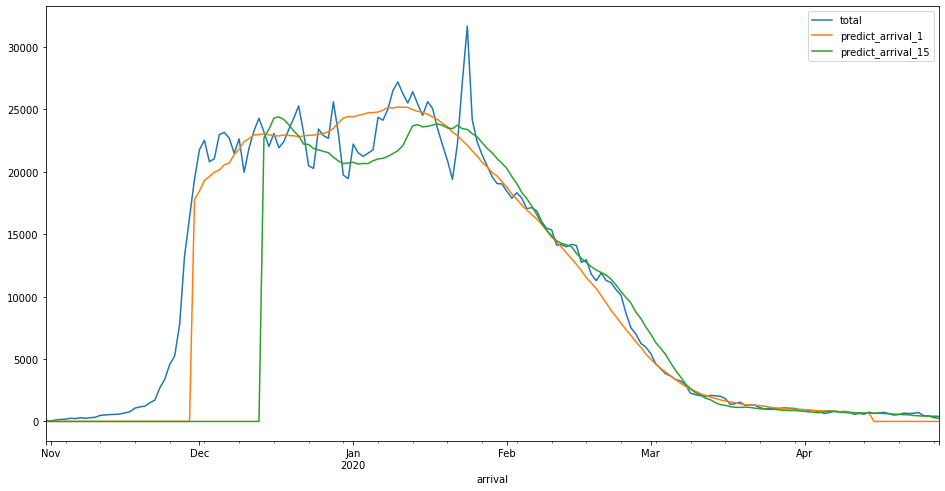

In [40]:
compare_backdata(predit_y)

In [41]:
# 	1.7 통합 향후 15일 예측
# 		1.7.1 testset (마지막 30일)의 inference

test_x = test_x.reshape(-1,window,size)
predit_y = model.predict(test_x)
predit_y, predit_y.shape

(array([[559.3223 , 540.6662 , 550.56744, 531.0229 , 528.7593 , 530.5412 ,
         532.58356, 518.7696 , 537.6527 , 506.25513, 523.52783, 481.11783,
         495.43384, 499.73105, 479.83206]], dtype=float32), (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,559.322327,2330
1,2020-04-30,540.666199,2252
2,2020-05-01,550.567444,2294
3,2020-05-02,531.022888,2212
4,2020-05-03,528.759277,2203
5,2020-05-04,530.541199,2210
6,2020-05-05,532.583557,2219
7,2020-05-06,518.769592,2161
8,2020-05-07,537.652710,2240
9,2020-05-08,506.255127,2109


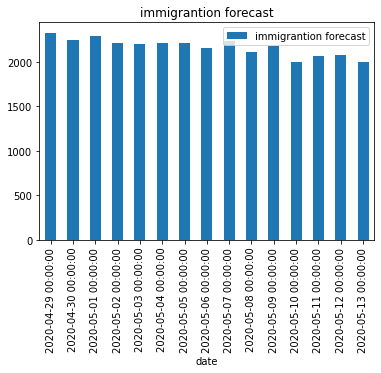

In [42]:
# 		1.7.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

display_result(predit_y)

In [43]:
#	1.8 ensemble에 의한 15일 예측
#		1.8.1 train 100회 시행

# 일관된 예측 결과를 만들기 위해, 동일 모델 100개의 앙상블 처리
# 시간 무지 오래 걸림 식사하고 오세요~

import dill

ensemble = []
for i in range(10):
  model,hist = train_combined_model(i+1,epochs=100,verbose=0,metrics=['mae','acc'])
  ensemble.append(model)
    
print("Wait! saving model...")    
file = open("ensemble.mdl", 'wb')
dill.dump(ensemble, file)
file.close()
        
print("Complete!!")


1 th Trial
learning:100/100[==================================================]{'loss': 2893366.875912409, 'mae': 1096.686, 'acc': 0.1459854}
2 th Trial
learning:100/100[==================================================]{'loss': 2600096.4826642335, 'mae': 968.2059, 'acc': 0.42335767}
3 th Trial
learning:100/100[==================================================]{'loss': 2559816.859489051, 'mae': 970.79755, 'acc': 0.4379562}
4 th Trial
learning:100/100[==================================================]{'loss': 2524431.534671533, 'mae': 943.9799, 'acc': 0.42335767}
5 th Trial
learning:100/100[==================================================]{'loss': 2607281.9283759124, 'mae': 986.9431, 'acc': 0.43065694}
6 th Trial
learning:100/100[==================================================]{'loss': 2654161.598540146, 'mae': 985.6963, 'acc': 0.43065694}
7 th Trial
learning:100/100[==================================================]{'loss': 2788696.72080292, 'mae': 1051.605, 'acc': 0.3941606}


In [0]:
if True == 0:
    print("load from model file...")
    file = open("ensemble.mdl", 'rb')
    ensemble = dill.load(file)
    file.close()

# 		ensemble_predict method define~
def ensemble_predict(input_x):

    ensemble_predit_y =  np.asarray([m.predict(input_x) for m in ensemble])
    predit_y = np.mean(ensemble_predit_y,axis=0)
    return predit_y, ensemble_predit_y

In [45]:
#		1.8.2 trainset에 의한 입국자(로밍등록자) 예측 역산 

predit_y,ensemble_predit_y = ensemble_predict(train_x)
predit_y,predit_y.shape

(array([[16237.394  , 16332.456  , 16560.41   , ..., 19581.348  ,
         19555.32   , 19724.941  ],
        [17707.057  , 17829.617  , 18078.082  , ..., 21280.197  ,
         21269.26   , 21451.77   ],
        [19368.701  , 19538.799  , 19794.902  , ..., 23155.71   ,
         23160.02   , 23354.934  ],
        ...,
        [  637.19446,   628.8656 ,   612.3473 , ...,   527.0487 ,
           532.0364 ,   511.33188],
        [  631.30457,   621.5609 ,   604.25183, ...,   519.2354 ,
           522.942  ,   502.6224 ],
        [  609.7855 ,   601.21326,   584.15106, ...,   506.71185,
           511.02362,   490.63678]], dtype=float32), (137, 15))

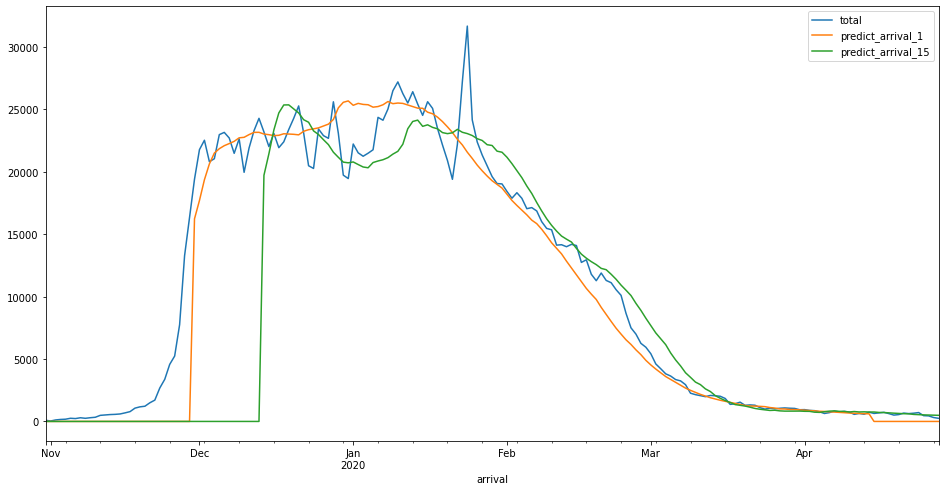

In [46]:
compare_backdata(predit_y)

In [47]:
#		1.8.3 testset (마지막 30일)의 inference

test_x = test_x.reshape(-1,window,size)

predit_y,ensemble_predit_y = ensemble_predict(test_x)
predit_y, predit_y.shape

(array([[564.13696, 560.3519 , 552.73193, 550.56415, 549.2602 , 553.5518 ,
         553.81354, 556.5395 , 550.35693, 549.63586, 547.6122 , 552.4592 ,
         552.71436, 559.89856, 547.6244 ]], dtype=float32), (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,564.136963,2350
1,2020-04-30,560.351929,2334
2,2020-05-01,552.731934,2303
3,2020-05-02,550.564148,2294
4,2020-05-03,549.260193,2288
5,2020-05-04,553.551819,2306
6,2020-05-05,553.813538,2307
7,2020-05-06,556.539490,2318
8,2020-05-07,550.356934,2293
9,2020-05-08,549.635864,2290


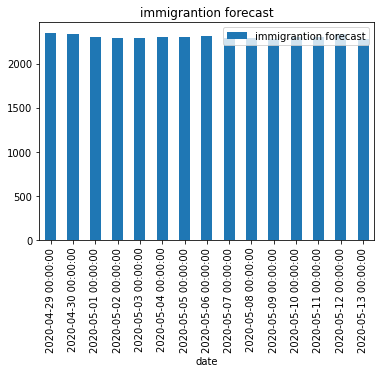

In [48]:
#		
display_result(predit_y)

In [49]:
#		1.8.3 신뢰수준 95%에서 입국자 예측 결과   

#100회 시행기준, 통계적 신뢰수준 95에서 %일자별 예측 입국자 구간 분석

import numpy as np
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
       a = 1.0*np.array(data)
       n = len(a)
       m, se = np.mean(a), scipy.stats.sem(a)
       h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
       std = np.std(np.array(data))
       return m, m-h, m+h,std 

predic_ds = []
# 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
#predit_y1 = predit_y * 100/24
from datetime import datetime, timedelta
last_date = raw_ds.index[-1]
ept = ensemble_predit_y.T
for forecast_d in ept[:,0,:]:
  last_date += timedelta(days=1)
  m, mi,ma,std = mean_confidence_interval(forecast_d)
  predic_ds.append({'date':last_date,'roaming register forecast(rrf)':int(m),'min rrf':int(mi),'max rrf':int(ma),'std':std,'immigrantion forecast':int(m * 100/24)})


print("Estimates of daily immigration forecasts at 95% confidence interval")
print("신뢰수준 95%에서 일별 예측 입국자수 구간추정")
predic_ds = pd.DataFrame(predic_ds)
predic_ds

Estimates of daily immigration forecasts at 95% confidence interval
신뢰수준 95%에서 일별 예측 입국자수 구간추정


,date,roaming register forecast(rrf),min rrf,max rrf,std,immigrantion forecast
0,2020-04-29,564,497,631,88.946129,2350
1,2020-04-30,560,497,623,83.740837,2334
2,2020-05-01,552,491,614,81.313622,2303
3,2020-05-02,550,496,604,71.563446,2294
4,2020-05-03,549,489,609,79.683456,2288
5,2020-05-04,553,488,618,86.385345,2306
6,2020-05-05,553,496,611,76.504784,2307
7,2020-05-06,556,489,623,88.286171,2318
8,2020-05-07,550,489,611,80.600037,2293
9,2020-05-08,549,484,614,85.813438,2290


In [0]:
# LSTM
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(units=size*2, return_sequences=True, input_shape=(window, size)))
model.add(Dropout(0.02))

model.add(LSTM(units=size*2, return_sequences=True))
model.add(Dropout(0.02))

model.add(LSTM(units=size*2, return_sequences=True))
model.add(Dropout(0.02))

model.add(LSTM(units=size*2))
model.add(Dropout(0.02))

model.add(Dense(forecast_days))
model.add(Activation('linear'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae',r2])

print(model.summary())

model_json = model.to_json()
with open("combined_model.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()

print("save to combined_model.json")



In [0]:
ensemble = []
for i in range(1):
  model,hist = train_combined_model(i+1,epochs=20,verbose=0,metrics=['mae',r2])
  ensemble.append(model)
    
print("Wait! saving model...")    
file = open("ensemble.mdl", 'wb')
dill.dump(ensemble, file)
file.close()
        
print("Complete!!")

In [0]:

predit_y,ensemble_predit_y = ensemble_predict(train_x)
predit_y,predit_y.shape

In [0]:
compare_backdata(predit_y)